In [10]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
from pydiffres import DiffRes
from tqdm import tqdm

class ESC50Dataset(Dataset):
    def __init__(self, csv_path, audio_dir, split="train", sr=16000):
        self.meta = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.sr = sr
        self.target_length = sr * 5  # 5 seconds (ESC-50 fixed)

        # Fold split (paper-style)
        if split == "train":
            self.meta = self.meta[self.meta["fold"] <= 3]
        elif split == "val":
            self.meta = self.meta[self.meta["fold"] == 4]
        else:
            self.meta = self.meta[self.meta["fold"] == 5]

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        path = os.path.join(self.audio_dir, row["filename"])

        # Load audio
        y, _ = librosa.load(path, sr=self.sr)

        # Fix length to 5s
        if len(y) < self.target_length:
            y = np.pad(y, (0, self.target_length - len(y)))
        else:
            y = y[:self.target_length]

        # Mel-spectrogram (10 ms hop → baseline paper)
        mel = librosa.feature.melspectrogram(
            y=y,
            sr=self.sr,
            n_fft=400,          # 25 ms window
            hop_length=160,     # 10 ms hop
            n_mels=128
        )
        mel = librosa.power_to_db(mel)

        # Shape: [F, T] dari librosa
        # PENTING: DiffRes expects [B, T, F]
        mel = torch.from_numpy(mel).float().transpose(0, 1)  # [T, F]

        label = int(row["target"])
        return mel, label


class ESC50DiffResNet(nn.Module):
    def __init__(self, T, F_dim=128, num_classes=50):
        super().__init__()

        # DiffRes module - expects input [B, T, F]
        self.diffres = DiffRes(
            in_t_dim=T,
            in_f_dim=F_dim,
            dimension_reduction_rate=0.5,
            learn_pos_emb=False
        )

        # Resize transform for EfficientNet input
        self.resize = transforms.Resize((224, 224))

        # Load pretrained EfficientNet-B2
        self.backbone = EfficientNet.from_pretrained("efficientnet-b2")
      
        # Freeze ALL backbone parameters (feature extractor)
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Replace classifier head with new one (automatically trainable)
        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Sequential(
            nn.Dropout(0.3),  # Regularization
            nn.Linear(in_features, num_classes)
        )


    def forward(self, x):
        """
        x: [B, T, F]
        T = temporal frames (e.g., 501)
        F = frequency bins (e.g., 128)
        """

        # DiffRes forward
        ret = self.diffres(x)

        feat = ret["feature"]
        guide_loss = ret["guide_loss"]
        
        # Debug print (comment out after debugging)
        # print(f"DiffRes output shape: {feat.shape}")
        
        # Flatten extra dimensions if necessary
        while feat.dim() > 3:
            # If shape is [B, C1, C2, T, F], flatten channel dims
            if feat.dim() == 5:
                B, C1, C2, T, F = feat.shape
                feat = feat.view(B, C1*C2, T, F)
            elif feat.dim() == 4:
                break
        
        # Now handle 3D or 4D tensor
        if feat.dim() == 3:
            # [B, T', F']
            feat = feat.unsqueeze(1)  # [B, 1, T', F']
        
        # feat should now be [B, C, T', F']
        # Transpose to [B, C, F', T'] for image-like format
        feat = feat.permute(0, 1, 3, 2)  # [B, C, F', T']
        
        # Ensure we have 3 channels
        if feat.shape[1] == 1:
            feat = feat.repeat(1, 3, 1, 1)   # [B, 3, F', T']
        elif feat.shape[1] != 3:
            # Adapt channels to 3
            feat = feat.mean(dim=1, keepdim=True).repeat(1, 3, 1, 1)
        
        # Resize to 224x224
        feat = self.resize(feat)         # [B, 3, 224, 224]

        out = self.backbone(feat)
        return out, guide_loss


def train_epoch(model, loader, criterion, optimizer, lambda_guide, device):
    model.train()
    total_loss, correct = 0, 0

    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out, guide_loss = model(x)

        cls_loss = criterion(out, y)
        loss = cls_loss + lambda_guide * guide_loss.mean()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out, _ = model(x)
            loss = criterion(out, y)

            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc


# Main training script
if __name__ == "__main__":
    # Create datasets
    train_ds = ESC50Dataset(
        "ESC-50-master/meta/esc50.csv",
        "ESC-50-master/audio",
        split="train"
    )
    val_ds = ESC50Dataset(
        "ESC-50-master/meta/esc50.csv",
        "ESC-50-master/audio",
        split="val"
    )
    test_ds = ESC50Dataset(
        "ESC-50-master/meta/esc50.csv",
        "ESC-50-master/audio",
        split="test"
    )

    # Create dataloaders
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=4)

    # Get device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Get temporal dimension from one sample
    sample_x, _ = train_ds[0]
    T = sample_x.shape[0]   # temporal dimension (should be 501)
    F = sample_x.shape[1]   # frequency dimension (should be 128)
    
    # print(f"Input shape: T={T}, F={F}")

    # Create model
    model = ESC50DiffResNet(T=T, F_dim=F).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2.5e-4)

    # ============================
    # Scheduler (Paper: 41, 0.95, 1)
    # ============================
    def lr_lambda(epoch):
        # epoch is 0-based
        if epoch < 40:     # epoch 1–40
            return 1.0
        else:              # epoch >= 41
            return 0.95 ** (epoch - 40)

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Hyperparameters
    lambda_guide = 0.5
    epochs = 80

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Training loop
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, lambda_guide, device
        )
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)

        # STEP scheduler (once per epoch) ✅
        scheduler.step()

        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        current_lr = optimizer.param_groups[0]["lr"]

        print(f"Epoch {epoch+1}/{epochs}")
        print(f" LR {current_lr:.6e}")
        print(f" Train Loss {train_loss:.4f} | Acc {train_acc:.4f}")
        print(f" Val   Loss {val_loss:.4f} | Acc {val_acc:.4f}")

    # Final test evaluation
    test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)
    print(f"\nFinal Test Accuracy: {test_acc:.4f}")

Using device: cuda
Loaded pretrained weights for efficientnet-b2


  1%|▏         | 1/75 [00:02<02:44,  2.23s/it]/home/sirius/Documents/DS/Tugas DL/pa_env/lib/python3.10/site-packages/pydiffres/core.py:314: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  activeness = torch.std(importance_score[id][~score_mask[id]])
100%|██████████| 75/75 [00:29<00:00,  2.50it/s]


Epoch 1/80
 LR 2.500000e-04
 Train Loss 4.0774 | Acc 0.0367
 Val   Loss 96.5720 | Acc 0.0300


100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


Epoch 2/80
 LR 2.500000e-04
 Train Loss 3.8281 | Acc 0.1583
 Val   Loss 3.6496 | Acc 0.1950


100%|██████████| 75/75 [00:29<00:00,  2.50it/s]


Epoch 3/80
 LR 2.500000e-04
 Train Loss 3.6182 | Acc 0.2808
 Val   Loss 3.4150 | Acc 0.3000


100%|██████████| 75/75 [00:28<00:00,  2.67it/s]


Epoch 4/80
 LR 2.500000e-04
 Train Loss 3.4431 | Acc 0.3650
 Val   Loss 3.2246 | Acc 0.4300


100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


Epoch 5/80
 LR 2.500000e-04
 Train Loss 3.3040 | Acc 0.3908
 Val   Loss 3.0822 | Acc 0.4275


100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


Epoch 6/80
 LR 2.500000e-04
 Train Loss 3.1259 | Acc 0.4658
 Val   Loss 2.9423 | Acc 0.4650


100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


Epoch 7/80
 LR 2.500000e-04
 Train Loss 2.9854 | Acc 0.4942
 Val   Loss 2.8494 | Acc 0.4800


100%|██████████| 75/75 [00:29<00:00,  2.59it/s]


Epoch 8/80
 LR 2.500000e-04
 Train Loss 2.8484 | Acc 0.5533
 Val   Loss 2.7514 | Acc 0.4725


100%|██████████| 75/75 [00:27<00:00,  2.71it/s]


Epoch 9/80
 LR 2.500000e-04
 Train Loss 2.7834 | Acc 0.5200
 Val   Loss 2.6929 | Acc 0.4825


100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


Epoch 10/80
 LR 2.500000e-04
 Train Loss 2.6999 | Acc 0.5417
 Val   Loss 2.5718 | Acc 0.5000


100%|██████████| 75/75 [00:27<00:00,  2.73it/s]


Epoch 11/80
 LR 2.500000e-04
 Train Loss 2.5925 | Acc 0.5742
 Val   Loss 2.5232 | Acc 0.5050


100%|██████████| 75/75 [00:27<00:00,  2.70it/s]


Epoch 12/80
 LR 2.500000e-04
 Train Loss 2.5242 | Acc 0.5725
 Val   Loss 2.4635 | Acc 0.5075


100%|██████████| 75/75 [00:27<00:00,  2.69it/s]


Epoch 13/80
 LR 2.500000e-04
 Train Loss 2.4234 | Acc 0.6008
 Val   Loss 2.4021 | Acc 0.5000


100%|██████████| 75/75 [00:31<00:00,  2.37it/s]


Epoch 14/80
 LR 2.500000e-04
 Train Loss 2.3349 | Acc 0.6192
 Val   Loss 2.3216 | Acc 0.5100


100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


Epoch 15/80
 LR 2.500000e-04
 Train Loss 2.2656 | Acc 0.6158
 Val   Loss 2.2457 | Acc 0.5375


100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch 16/80
 LR 2.500000e-04
 Train Loss 2.2075 | Acc 0.6133
 Val   Loss 2.2544 | Acc 0.5250


100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


Epoch 17/80
 LR 2.500000e-04
 Train Loss 2.1823 | Acc 0.6108
 Val   Loss 2.1880 | Acc 0.5450


100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


Epoch 18/80
 LR 2.500000e-04
 Train Loss 2.1085 | Acc 0.6142
 Val   Loss 2.1788 | Acc 0.5400


100%|██████████| 75/75 [00:32<00:00,  2.29it/s]


Epoch 19/80
 LR 2.500000e-04
 Train Loss 2.0695 | Acc 0.6317
 Val   Loss 2.1144 | Acc 0.5325


100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


Epoch 20/80
 LR 2.500000e-04
 Train Loss 2.0120 | Acc 0.6358
 Val   Loss 2.1063 | Acc 0.5350


100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


Epoch 21/80
 LR 2.500000e-04
 Train Loss 2.0028 | Acc 0.6475
 Val   Loss 2.0459 | Acc 0.5475


100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


Epoch 22/80
 LR 2.500000e-04
 Train Loss 1.9409 | Acc 0.6500
 Val   Loss 2.0219 | Acc 0.5425


100%|██████████| 75/75 [00:30<00:00,  2.47it/s]


Epoch 23/80
 LR 2.500000e-04
 Train Loss 1.9056 | Acc 0.6700
 Val   Loss 2.0014 | Acc 0.5450


100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch 24/80
 LR 2.500000e-04
 Train Loss 1.8724 | Acc 0.6400
 Val   Loss 1.9950 | Acc 0.5500


100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


Epoch 25/80
 LR 2.500000e-04
 Train Loss 1.7886 | Acc 0.6842
 Val   Loss 1.9172 | Acc 0.5800


100%|██████████| 75/75 [00:27<00:00,  2.69it/s]


Epoch 26/80
 LR 2.500000e-04
 Train Loss 1.8351 | Acc 0.6642
 Val   Loss 1.9173 | Acc 0.5825


100%|██████████| 75/75 [00:28<00:00,  2.59it/s]


Epoch 27/80
 LR 2.500000e-04
 Train Loss 1.7988 | Acc 0.6742
 Val   Loss 1.9564 | Acc 0.5325


100%|██████████| 75/75 [00:32<00:00,  2.33it/s]


Epoch 28/80
 LR 2.500000e-04
 Train Loss 1.7345 | Acc 0.6775
 Val   Loss 1.9030 | Acc 0.5450


100%|██████████| 75/75 [00:31<00:00,  2.36it/s]


Epoch 29/80
 LR 2.500000e-04
 Train Loss 1.6919 | Acc 0.6892
 Val   Loss 1.8340 | Acc 0.5625


100%|██████████| 75/75 [00:32<00:00,  2.34it/s]


Epoch 30/80
 LR 2.500000e-04
 Train Loss 1.6889 | Acc 0.6800
 Val   Loss 1.8502 | Acc 0.5750


100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


Epoch 31/80
 LR 2.500000e-04
 Train Loss 1.6668 | Acc 0.6983
 Val   Loss 1.8304 | Acc 0.5650


100%|██████████| 75/75 [00:28<00:00,  2.60it/s]


Epoch 32/80
 LR 2.500000e-04
 Train Loss 1.6351 | Acc 0.7017
 Val   Loss 1.7941 | Acc 0.5975


100%|██████████| 75/75 [00:31<00:00,  2.38it/s]


Epoch 33/80
 LR 2.500000e-04
 Train Loss 1.6182 | Acc 0.7000
 Val   Loss 1.7960 | Acc 0.5650


100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


Epoch 34/80
 LR 2.500000e-04
 Train Loss 1.5649 | Acc 0.7192
 Val   Loss 1.7747 | Acc 0.5575


100%|██████████| 75/75 [00:30<00:00,  2.45it/s]


Epoch 35/80
 LR 2.500000e-04
 Train Loss 1.5821 | Acc 0.6925
 Val   Loss 1.7615 | Acc 0.5600


100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch 36/80
 LR 2.500000e-04
 Train Loss 1.5916 | Acc 0.6900
 Val   Loss 1.7325 | Acc 0.5750


100%|██████████| 75/75 [00:30<00:00,  2.48it/s]


Epoch 37/80
 LR 2.500000e-04
 Train Loss 1.5026 | Acc 0.7192
 Val   Loss 1.7404 | Acc 0.5700


100%|██████████| 75/75 [00:29<00:00,  2.59it/s]


Epoch 38/80
 LR 2.500000e-04
 Train Loss 1.5330 | Acc 0.7117
 Val   Loss 1.7368 | Acc 0.5500


100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


Epoch 39/80
 LR 2.500000e-04
 Train Loss 1.4975 | Acc 0.7175
 Val   Loss 1.7465 | Acc 0.5650


100%|██████████| 75/75 [00:27<00:00,  2.75it/s]


Epoch 40/80
 LR 2.500000e-04
 Train Loss 1.5060 | Acc 0.7167
 Val   Loss 1.7349 | Acc 0.5800


100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


Epoch 41/80
 LR 2.375000e-04
 Train Loss 1.4733 | Acc 0.7092
 Val   Loss 1.7128 | Acc 0.5650


100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


Epoch 42/80
 LR 2.256250e-04
 Train Loss 1.4470 | Acc 0.7150
 Val   Loss 1.6844 | Acc 0.5725


100%|██████████| 75/75 [00:27<00:00,  2.68it/s]


Epoch 43/80
 LR 2.143437e-04
 Train Loss 1.4313 | Acc 0.7150
 Val   Loss 1.7041 | Acc 0.5550


100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


Epoch 44/80
 LR 2.036266e-04
 Train Loss 1.3984 | Acc 0.7233
 Val   Loss 1.7123 | Acc 0.5675


100%|██████████| 75/75 [00:32<00:00,  2.34it/s]


Epoch 45/80
 LR 1.934452e-04
 Train Loss 1.3715 | Acc 0.7342
 Val   Loss 1.6663 | Acc 0.5700


100%|██████████| 75/75 [00:31<00:00,  2.39it/s]


Epoch 46/80
 LR 1.837730e-04
 Train Loss 1.4005 | Acc 0.7300
 Val   Loss 1.6644 | Acc 0.5825


100%|██████████| 75/75 [00:31<00:00,  2.36it/s]


Epoch 47/80
 LR 1.745843e-04
 Train Loss 1.3609 | Acc 0.7375
 Val   Loss 1.6353 | Acc 0.5850


100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Epoch 48/80
 LR 1.658551e-04
 Train Loss 1.4044 | Acc 0.7242
 Val   Loss 1.6451 | Acc 0.5975


100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


Epoch 49/80
 LR 1.575624e-04
 Train Loss 1.3805 | Acc 0.7392
 Val   Loss 1.6691 | Acc 0.5950


100%|██████████| 75/75 [00:31<00:00,  2.41it/s]


Epoch 50/80
 LR 1.496842e-04
 Train Loss 1.3731 | Acc 0.7258
 Val   Loss 1.6791 | Acc 0.5750


100%|██████████| 75/75 [00:32<00:00,  2.29it/s]


Epoch 51/80
 LR 1.422000e-04
 Train Loss 1.3459 | Acc 0.7517
 Val   Loss 1.6519 | Acc 0.5800


100%|██████████| 75/75 [00:31<00:00,  2.39it/s]


Epoch 52/80
 LR 1.350900e-04
 Train Loss 1.3037 | Acc 0.7408
 Val   Loss 1.6340 | Acc 0.5775


100%|██████████| 75/75 [00:30<00:00,  2.44it/s]


Epoch 53/80
 LR 1.283355e-04
 Train Loss 1.3467 | Acc 0.7367
 Val   Loss 1.6122 | Acc 0.5750


100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch 54/80
 LR 1.219187e-04
 Train Loss 1.3672 | Acc 0.7333
 Val   Loss 1.6588 | Acc 0.5700


100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


Epoch 55/80
 LR 1.158228e-04
 Train Loss 1.3622 | Acc 0.7392
 Val   Loss 1.6602 | Acc 0.5625


100%|██████████| 75/75 [00:30<00:00,  2.42it/s]


Epoch 56/80
 LR 1.100317e-04
 Train Loss 1.3634 | Acc 0.7267
 Val   Loss 1.6330 | Acc 0.5750


100%|██████████| 75/75 [00:28<00:00,  2.60it/s]


Epoch 57/80
 LR 1.045301e-04
 Train Loss 1.3371 | Acc 0.7325
 Val   Loss 1.6363 | Acc 0.5850


100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


Epoch 58/80
 LR 9.930358e-05
 Train Loss 1.3390 | Acc 0.7500
 Val   Loss 1.6587 | Acc 0.5625


100%|██████████| 75/75 [00:28<00:00,  2.59it/s]


Epoch 59/80
 LR 9.433840e-05
 Train Loss 1.3017 | Acc 0.7525
 Val   Loss 1.6451 | Acc 0.5800


100%|██████████| 75/75 [00:28<00:00,  2.60it/s]


Epoch 60/80
 LR 8.962148e-05
 Train Loss 1.2852 | Acc 0.7642
 Val   Loss 1.6216 | Acc 0.5825


100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


Epoch 61/80
 LR 8.514041e-05
 Train Loss 1.3305 | Acc 0.7242
 Val   Loss 1.6339 | Acc 0.5675


100%|██████████| 75/75 [00:32<00:00,  2.31it/s]


Epoch 62/80
 LR 8.088339e-05
 Train Loss 1.2634 | Acc 0.7567
 Val   Loss 1.6411 | Acc 0.5650


100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch 63/80
 LR 7.683922e-05
 Train Loss 1.3053 | Acc 0.7525
 Val   Loss 1.6413 | Acc 0.5675


100%|██████████| 75/75 [00:28<00:00,  2.63it/s]


Epoch 64/80
 LR 7.299726e-05
 Train Loss 1.2759 | Acc 0.7567
 Val   Loss 1.5722 | Acc 0.5875


100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


Epoch 65/80
 LR 6.934739e-05
 Train Loss 1.2936 | Acc 0.7375
 Val   Loss 1.5904 | Acc 0.5800


100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


Epoch 66/80
 LR 6.588002e-05
 Train Loss 1.2771 | Acc 0.7508
 Val   Loss 1.5822 | Acc 0.5875


100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


Epoch 67/80
 LR 6.258602e-05
 Train Loss 1.3047 | Acc 0.7483
 Val   Loss 1.6107 | Acc 0.5725


100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


Epoch 68/80
 LR 5.945672e-05
 Train Loss 1.2716 | Acc 0.7550
 Val   Loss 1.6262 | Acc 0.5575


100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


Epoch 69/80
 LR 5.648389e-05
 Train Loss 1.2627 | Acc 0.7617
 Val   Loss 1.6273 | Acc 0.5550


100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


Epoch 70/80
 LR 5.365969e-05
 Train Loss 1.2633 | Acc 0.7608
 Val   Loss 1.5850 | Acc 0.6125


100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


Epoch 71/80
 LR 5.097671e-05
 Train Loss 1.2747 | Acc 0.7508
 Val   Loss 1.6132 | Acc 0.5825


100%|██████████| 75/75 [00:28<00:00,  2.67it/s]


Epoch 72/80
 LR 4.842787e-05
 Train Loss 1.2288 | Acc 0.7625
 Val   Loss 1.6020 | Acc 0.5675


100%|██████████| 75/75 [00:28<00:00,  2.65it/s]


Epoch 73/80
 LR 4.600648e-05
 Train Loss 1.2684 | Acc 0.7625
 Val   Loss 1.5790 | Acc 0.5900


100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


Epoch 74/80
 LR 4.370615e-05
 Train Loss 1.2924 | Acc 0.7425
 Val   Loss 1.6287 | Acc 0.5625


100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


Epoch 75/80
 LR 4.152085e-05
 Train Loss 1.2296 | Acc 0.7742
 Val   Loss 1.6315 | Acc 0.5425


100%|██████████| 75/75 [00:27<00:00,  2.71it/s]


Epoch 76/80
 LR 3.944480e-05
 Train Loss 1.2635 | Acc 0.7367
 Val   Loss 1.6347 | Acc 0.5625


100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


Epoch 77/80
 LR 3.747256e-05
 Train Loss 1.2397 | Acc 0.7517
 Val   Loss 1.5988 | Acc 0.5850


100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


Epoch 78/80
 LR 3.559894e-05
 Train Loss 1.2615 | Acc 0.7567
 Val   Loss 1.5980 | Acc 0.5625


100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


Epoch 79/80
 LR 3.381899e-05
 Train Loss 1.2678 | Acc 0.7558
 Val   Loss 1.5747 | Acc 0.5775


100%|██████████| 75/75 [00:28<00:00,  2.62it/s]


Epoch 80/80
 LR 3.212804e-05
 Train Loss 1.2485 | Acc 0.7433
 Val   Loss 1.5828 | Acc 0.5875

Final Test Accuracy: 0.5450


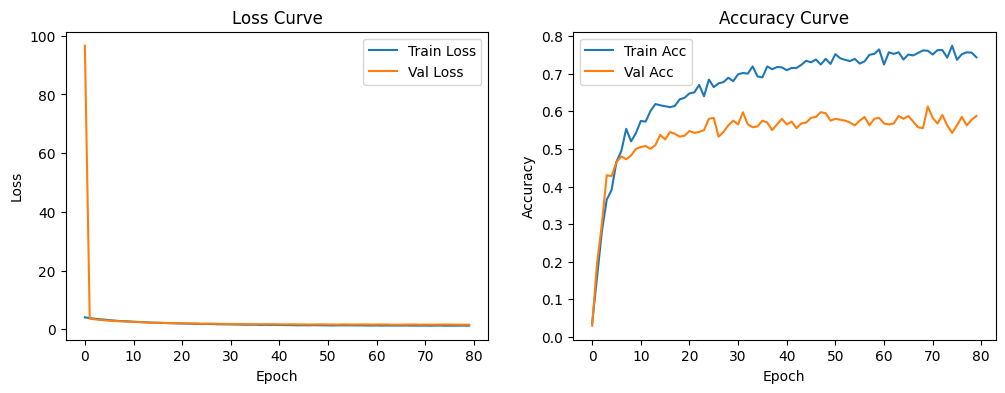

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [3]:
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.6575


In [12]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
from pydiffres import DiffRes
from tqdm import tqdm


In [13]:
class ESC50Dataset(Dataset):
    def __init__(self, csv_path, audio_dir, split="train", sr=16000):
        self.meta = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.sr = sr
        self.target_length = sr * 5  # 5 seconds (ESC-50 fixed)

        # Fold split (paper-style)
        if split == "train":
            self.meta = self.meta[self.meta["fold"] <= 3]
        elif split == "val":
            self.meta = self.meta[self.meta["fold"] == 4]
        else:
            self.meta = self.meta[self.meta["fold"] == 5]

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        path = os.path.join(self.audio_dir, row["filename"])

        # Load audio
        y, _ = librosa.load(path, sr=self.sr)

        # Fix length to 5s
        if len(y) < self.target_length:
            y = np.pad(y, (0, self.target_length - len(y)))
        else:
            y = y[:self.target_length]

        # Mel-spectrogram (10 ms hop → baseline paper)
        mel = librosa.feature.melspectrogram(
            y=y,
            sr=self.sr,
            n_fft=400,          # 25 ms window
            hop_length=160,     # 10 ms hop
            n_mels=128
        )
        mel = librosa.power_to_db(mel)

        # Shape: [T, F]
        mel = torch.from_numpy(mel).float().transpose(0, 1)

        label = int(row["target"])
        return mel, label


In [14]:
train_ds = ESC50Dataset(
    "ESC-50-master/meta/esc50.csv",
    "ESC-50-master/audio",
    split="train"
)
val_ds = ESC50Dataset(
    "ESC-50-master/meta/esc50.csv",
    "ESC-50-master/audio",
    split="val"
)
test_ds = ESC50Dataset(
    "ESC-50-master/meta/esc50.csv",
    "ESC-50-master/audio",
    split="test"
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)


In [15]:
class ESC50DiffResNet(nn.Module):
    def __init__(self, T, F_dim=128, num_classes=50):
        super().__init__()

        self.diffres = DiffRes(
            in_t_dim=T,
            in_f_dim=F_dim,
            dimension_reduction_rate=0.5,
            learn_pos_emb=False
        )

        self.resize = transforms.Resize((224, 224))

        self.backbone = EfficientNet.from_pretrained("efficientnet-b2")
        for p in self.backbone.parameters():
            p.requires_grad = True

        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        """
        x: [B, T, F]
        """

        # ---- DiffRes (NO channel here) ----
        ret = self.diffres(x)

        feat = ret["feature"]       # [B, T', F']
        guide_loss = ret["guide_loss"]

        # ---- Convert to image for EfficientNet ----
        feat = feat.unsqueeze(1)    # [B, 1, T', F']
        feat = feat.permute(0, 1, 3, 2)  # [B, 1, F', T']
        feat = feat.repeat(1, 3, 1, 1)   # [B, 3, F', T']
        feat = self.resize(feat)         # [B, 3, 224, 224]

        out = self.backbone(feat)
        return out, guide_loss

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hitung T dari satu sample
sample_x, _ = train_ds[0]
T = sample_x.shape[1]   # time dimension

model = ESC50DiffResNet(T=T).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2.5e-4)

lambda_guide = 0.5

Loaded pretrained weights for efficientnet-b2


In [17]:
def train_epoch(loader):
    model.train()
    total_loss, correct = 0, 0

    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out, guide_loss = model(x)

        cls_loss = criterion(out, y)
        loss = cls_loss + lambda_guide * guide_loss.mean()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc


def eval_epoch(loader):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out, _ = model(x)
            loss = criterion(out, y)

            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc


In [18]:
epochs = 30

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc = eval_epoch(val_loader)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f" Train Loss {train_loss:.4f} | Acc {train_acc:.4f}")
    print(f" Val   Loss {val_loss:.4f} | Acc {val_acc:.4f}")


  0%|          | 0/38 [00:07<?, ?it/s]


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [32, 501] but got: [32, 128].